In [1]:
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import datetime
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Any results you write to the current directory are saved as output.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [13]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    """Функции для предобработки"""

    # Функция для очистки данных и создания списка

    def clean(x):
        x = x.replace('[','').replace(']','').replace("'",'')
        return x
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'] = df_output['Number of Reviews'].fillna(0)
    df_output['Reviews'] = df_output['Reviews'].fillna('[[], []]')
    # Заполним пропуски самой распрастранненой ценовой категорией
    df_output['Price Range'] = df_output['Price Range'].fillna(data['Price Range'].mode()[0])
    # Пропуски заполним типом кухни 'Other'
    df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna('Other')
    
    # ################### 3. Encoding ############################################################## 
    #Применим функцию det_dummies  к колонке с городами
    df_output['City_copy'] = df_output['City']
    df_output = pd.get_dummies(df_output, columns=[ 'City_copy',], dummy_na=True)
    # Применим функцию для обработки данных в рабочие списки
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: clean(x).split(','))
    # Составим список менее популярных кухонь, оставив топ 100
    cuisine_styles_drop = df_output['Cuisine Style'].str.get_dummies(', ').sum().sort_values(ascending=False)[100:]
    # Присоединим получившийся датафрейм новых признаков из топ 100 кухонь
    df_output = df_output.join(df_output['Cuisine Style'].str.get_dummies(', ').drop(cuisine_styles_drop.index, axis = 1), how = 'left')    
    # Также добавим столбец с количеством представленных кухонь в ресторане
    df_output['Cuisine_Style_count'] = df_output['Cuisine Style'].apply(lambda x: len(x))
    # Заменим данные столбца на цифровое обозначение цен ($ - 1, $$ - $$$ - 2, $$$$ - 3) 
    Price_Range_dict = {None: None, '$': '1', '$$ - $$$': '2', '$$$$': '3'}
    df_output['Price Range'] = df_output['Price Range'].replace(to_replace=Price_Range_dict)
    df_output['Price Range'] = df_output.apply(lambda x: float(x['Price Range']), axis = 1)
    # Выделим даты из столбца Reviews
    df_output['Reviews_date'] = df_output['Reviews'].str.findall('\d+/\d+/\d+')
    # Уберем лишнюю дату из отзывов
    df_output['Reviews_date'] = df_output['Reviews_date'].apply(lambda x: x[1:] if len(x) == 3 else x)
    # Создадим столбец с количеством дней после последнего отзыва
    df_output['Reviews_date_delta_from_now']=df_output['Reviews_date'].apply(lambda x:  datetime.now()-pd.to_datetime(x).max()
                                                                            ).apply(lambda x: x.days)
    #Создадим столбец с количеством дней между последними отзывами
    df_output['Reviews_date_delta']=df_output['Reviews_date'].apply(lambda x: pd.to_datetime(x).max()-pd.to_datetime(x).min()
                                                              ).apply(lambda x: x.days)
    # Заполним пропуски медианой
    df_output['Reviews_date_delta_from_now']=df_output['Reviews_date_delta_from_now'].fillna(df_output['Reviews_date_delta_from_now'].max())
    df_output['Reviews_date_delta']=df_output['Reviews_date_delta'].fillna(df_output['Reviews_date_delta'].max())
    
    # ################### 4. Feature Engineering ####################################################
        # Находим среднее значение по городам
    min_Ranking = df_output.groupby(by='City')['Ranking'].min()
    # Находим стандартное отклонение значений Ranking по городам
    max_Ranking = df_output.groupby(by='City')['Ranking'].max()
    # Добавляем колоки в наш датафрейм с этими значениями относительно каждого города
    df_output['min_Ranking'] = df_output['City'].apply(lambda x: min_Ranking[x])
    df_output['max_Ranking'] = df_output['City'].apply(lambda x: max_Ranking[x])
    # Выполним min_max нормализацию Ranking в новый столбец
    df_output['min_max_norm_Ranking'] = (df_output['Ranking'] - df_output['min_Ranking'])/(df_output['max_Ranking']-df_output['min_Ranking'])
       
    # Выполним нормализацию Ranking относительно количества ресторанов в городе   
    mean_Ranking = df_output.groupby(['City'])['Ranking'].mean()
    count_Restorant = df_output['City'].value_counts(ascending=False)
    df_output['mean_Ranking'] = df_output['City'].apply(lambda x: mean_Ranking[x])
    df_output['count_Restorant'] = df_output['City'].apply(lambda x: count_Restorant[x])
    df_output['norm_Ranking'] = (df_output['Ranking'] - df_output['mean_Ranking']) / df_output['count_Restorant']    
        
    # ################### 5. Clean #################################################### 
    # модель на признаках с dtypes "object" обучаться не будет, просто их удалим
    df_output.drop(columns = ['Ranking','City','Cuisine Style','Restaurant_id','Reviews','URL_TA','ID_TA','Reviews_date'], axis = 1, inplace=True)  
    
   
    return df_output

In [14]:
df_preproc = preproc_data(data)
df_preproc.head(10)

,Price Range,Number of Reviews,sample,Rating,City_copy_Amsterdam,City_copy_Athens,City_copy_Barcelona,City_copy_Berlin,City_copy_Bratislava,City_copy_Brussels,...,['Vegetarian Friendly'],Cuisine_Style_count,Reviews_date_delta_from_now,Reviews_date_delta,min_Ranking,max_Ranking,min_max_norm_Ranking,mean_Ranking,count_Restorant,norm_Ranking
0,2.0,4.0,0,0.0,0,0,0,0,0,0,...,0,2,6044.0,3296.0,3.0,13986.0,0.926840,6938.557138,6108,0.986320
1,2.0,97.0,0,0.0,0,0,0,0,0,0,...,0,5,1068.0,37.0,4.0,1141.0,0.089710,564.231579,475,-0.964698
2,2.0,28.0,0,0.0,0,0,0,0,0,0,...,1,1,1045.0,22.0,1.0,1766.0,0.458357,885.130201,745,-0.100846
3,3.0,202.0,0,0.0,0,0,0,0,0,0,...,0,5,1067.0,14.0,1.0,16444.0,0.101441,8169.707354,7193,-0.903755
4,3.0,162.0,0,0.0,0,0,0,0,1,0,...,0,6,1003.0,15.0,3.0,889.0,0.038375,462.428947,380,-1.119550
5,1.0,24.0,0,0.0,0,0,0,0,0,0,...,0,3,1157.0,5.0,3.0,13986.0,0.364013,6938.557138,6108,-0.302154
6,1.0,2.0,0,0.0,0,0,0,0,0,0,...,0,2,6044.0,3296.0,1.0,3717.0,0.996502,1867.330298,1647,1.115161
7,2.0,0.0,0,0.0,0,0,0,0,0,0,...,0,1,6044.0,3296.0,1.0,2440.0,0.954900,1219.061704,1021,1.088088
8,2.0,2.0,0,0.0,0,0,0,0,0,0,...,0,2,1035.0,88.0,4.0,1141.0,0.674582,564.231579,475,0.435302
9,2.0,13.0,0,0.0,0,0,0,0,0,0,...,0,1,1071.0,34.0,1.0,2464.0,0.245229,1237.482091,1033,-0.612277


In [15]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 145 entries, Price Range to norm_Ranking
dtypes: float64(10), int64(103), uint8(32)
memory usage: 44.6 MB


In [16]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.

In [17]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 144), (40000, 144), (40000, 143), (32000, 143), (8000, 143))

# Model
Сам ML

In [18]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [19]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [20]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


In [21]:
y_pred

array([4.355, 4.85 , 4.3  , ..., 4.58 , 4.22 , 4.02 ])

In [22]:
""" Выполним округление предсказанного рейтинга кратно 0.5, т.к. сам рейтинг представлен в таком виде """
np.round(y_pred*2)/2

array([4.5, 5. , 4.5, ..., 4.5, 4. , 4. ])

In [23]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.201923125


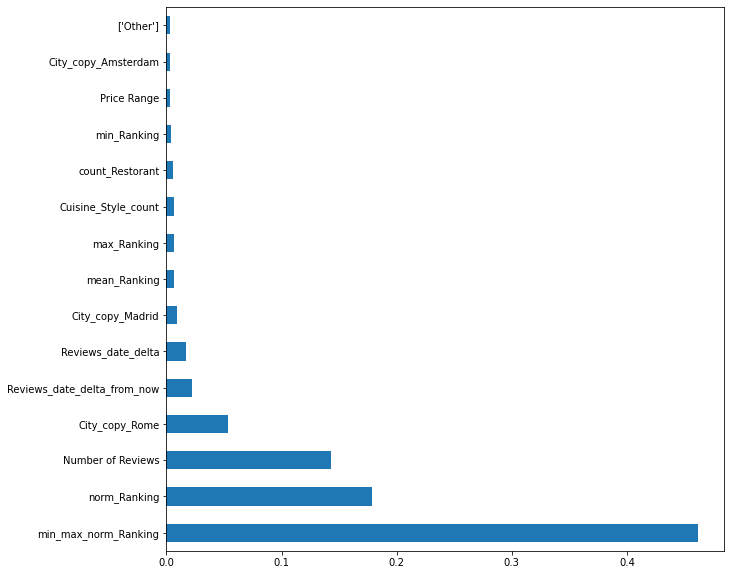

In [24]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission

In [25]:
test_data.sample(10)

,Price Range,Number of Reviews,Rating,City_copy_Amsterdam,City_copy_Athens,City_copy_Barcelona,City_copy_Berlin,City_copy_Bratislava,City_copy_Brussels,City_copy_Budapest,...,['Vegetarian Friendly'],Cuisine_Style_count,Reviews_date_delta_from_now,Reviews_date_delta,min_Ranking,max_Ranking,min_max_norm_Ranking,mean_Ranking,count_Restorant,norm_Ranking
4466,2.0,13.0,0.0,1,0,0,0,0,0,0,...,0,1,1040.0,284.0,1.0,3254.0,0.545035,1591.589650,1372,0.132952
5600,2.0,485.0,0.0,0,0,0,0,0,0,0,...,0,3,1067.0,47.0,3.0,13986.0,0.088965,6938.557138,6108,-0.931820
8481,2.0,2015.0,0.0,0,0,1,0,0,0,0,...,0,7,1035.0,4.0,5.0,7796.0,0.024002,3879.422680,3395,-1.086133
3714,2.0,80.0,0.0,0,0,0,1,0,0,0,...,0,2,1036.0,6.0,2.0,6372.0,0.059184,3255.417745,2705,-1.063371
7549,2.0,479.0,0.0,0,0,0,0,0,0,0,...,0,4,1148.0,36.0,1.0,5948.0,0.322347,2970.733102,2589,-0.406618
7361,2.0,545.0,0.0,0,0,0,0,0,0,0,...,0,5,1069.0,27.0,1.0,16444.0,0.077480,8169.707354,7193,-0.958530
7388,2.0,2.0,0.0,0,0,0,0,0,0,1,...,0,1,1306.0,0.0,1.0,2440.0,0.573596,1219.061704,1021,0.177217
4966,2.0,1245.0,0.0,0,0,1,0,0,0,0,...,0,7,1044.0,44.0,5.0,7796.0,0.085098,3879.422680,3395,-0.945927
3608,2.0,5.0,0.0,0,0,0,0,0,0,0,...,0,1,1496.0,292.0,3.0,13986.0,0.968033,6938.557138,6108,1.080623
4451,2.0,2.0,0.0,0,0,1,0,0,0,0,...,0,2,6044.0,3296.0,5.0,7796.0,0.969837,3879.422680,3395,1.084412


In [26]:
test_data = test_data.drop(['Rating'], axis=1)

In [27]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [28]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


In [29]:
predict_submission

array([3.09 , 4.235, 4.38 , ..., 3.14 , 4.435, 4.31 ])

In [30]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.090
1,id_1,4.235
2,id_2,4.380
3,id_3,4.310
4,id_4,4.480
5,id_5,4.415
6,id_6,2.160
7,id_7,2.875
8,id_8,4.180
9,id_9,4.690
